### Inverse Modelling: Demonstration of parameterisation of structure and history matching
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty
#### CREATING SYNTHETIC TRUTH

This notebook uses a simple example to show how the pinchout of a formation at an unconformity can be included in uncertainty analysis using parameterisation and estimation of parameters and forecasting.


In [1]:
import pandas as pd
import numpy as np
import subprocess
import sys
import os
import pickle
import functions # This is a project specific python script saved in folder functions.py

%load_ext autoreload
%autoreload 2
  
sys.path.append('../../MODFLOW_Tools')  
%run ./figures.ipynb                   # Contains functions to produce figures
logfunc = lambda e: np.log10(e)

### 1. Project parameters

In [2]:
from loop2flopy import Project
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# ------------- DISCRETISATION PARAMETERS -----------------------#
P.triExeName = '../exe/triangle.exe'
P.workspace = '../modelfiles/'
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = [(2000, 2000), (2500, 2000), (2000, 2500), (2500, 2500),] 
P.idpumpbores = ['P0','P1','P2','P3'] 
P.xyobsbores = [(1500,1000), (2500, 5000), (4000, 3000), (1500, 3500), (4500,4500)] 
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4', 'OB5'] 
P.nobs = len(P.xyobsbores)
P.nzobs = 3
P.npump = len(P.xypumpbores)

P.r = 40        # refining factor for model boundary. High r has refined edges
P.w = 100      # Interior boundary
P.boundmaxtri = 30000 
P.modelmaxtri = 30000 # 10000 for ref
P.angle = 34   # minimum triangle angles

P.radius1 = 100 # radius of inner circle around pumping bores
P.radius2 = 200 # radius of outer circle around pumping bores
P.boremaxtri = 100000

# ------------- FLOW MODEL PARAMETERS -----------------------#
P.mfexe_name = '../exe/mf6.exe'

P.nlg = 4    # number of geological layers
P.nls = 2    # Number sublayers for conformable
P.geo_pl = 2 # Which geological layer pumping from (zero-based)
P.res = 2    # vertical resolution upon which voxel grid created to pick lithology bottoms

P.hk = [1.7, 0.07, 8.2, 0.05] 
P.vk = [0.12,0.007,0.51,0.005] 
P.ss = [0.00009, 0.00007, 0.00002, 0.00008]
P.sy = [0.12, 0.1, 0.1, 0.1]

P.rch = 0.4/365 # 0.0027 m/d
P.strt = 0.

P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = True

past_years = 2
P.nts_past = past_years * 6
P.tdis_past = [(past_years * 365, P.nts_past, 1.1)] # period length, number of timesteps, tsmult
P.qwell_past = -2000 #m3/d 

future_years = 5
P.nts_future = future_years * 6
P.tdis_future = [(future_years * 365, P.nts_future, 1.1)] # period length, number of timesteps, tsmult
P.qwell_future = -5000 #m3/d 

pickle.dump([P.hk, P.vk, P.ss, P.sy], open('../results/reference.pkl','wb')) # Save hydraulic parameters of TRUTH MODEL   

loop2flopy routines loaded!


In [3]:
for i in P.hk: print(logfunc(i))
for i in P.vk: print(logfunc(i))
for i in P.ss: print(logfunc(i))

0.2304489213782739
-1.154901959985743
0.9138138523837167
-1.3010299956639813
-0.9208187539523752
-2.154901959985743
-0.2924298239020636
-2.3010299956639813
-4.045757490560675
-4.154901959985743
-4.698970004336019
-4.096910013008056


### 2. Meshing

Meshing routines loaded!


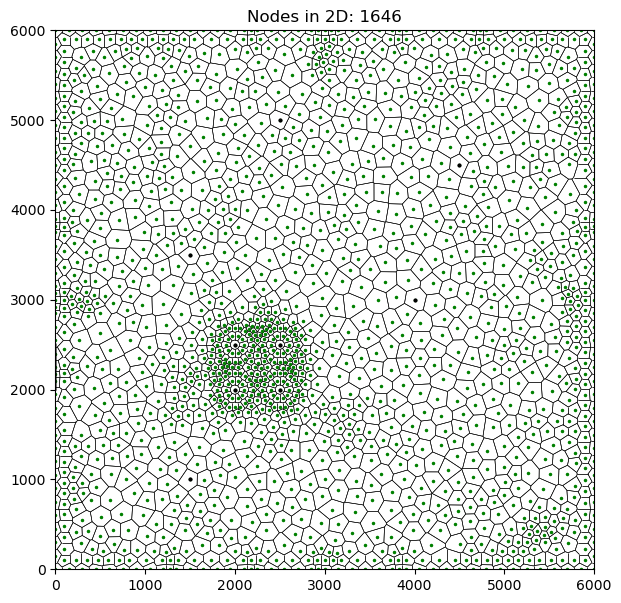

In [4]:
from meshing_routines import createcell2d
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, P.vornodes = createcell2d(P, grid = 'vor', fault = False)      

from meshing_routines import plot_cell2d_vor
plot_cell2d_vor(P, xlim = [P.x0, P.x1], ylim = [P.y0, P.y1]) #xlim = [0, 3500], ylim = [0, 3500]

P.nlv  = 30  
P.delx, P.dely = 40, 40
P.ncol, P.nrow = int((P.x1 - P.x0) / P.delx), int((P.y1 - P.y0) / P.dely)
P.cell2dcar, P.xcyccar, P.verticescar, P.sg = createcell2d(P, grid = 'car', fault = False)    

### 3. Geological model (Reference)

C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   ID data_type     X     Y      Z  val lithcode feature_name  gx  gy  gz
0  P1       raw   500   500  -50.0  -50        a        upper   0   0   1
1  P1       raw   500   500 -350.0 -100        b        lower   0   0   1
2  P1       raw   500   500 -450.0 -200        c        lower   0   0   1
3  P2       raw  2500  2500  -50.0  -50        a        upper   0   0   1
4  P2       raw  2500  2500 -150.0 -100        b        lower   0   0   1
5  P2       raw  2500  2500 -250.0 -200        c        lower   0   0   1
6  P3       raw  3000  3000    NaN  -50        a        upper   0   0   1
7  P3       raw  3000  3000    NaN -100        b        lower   0   0   1
8  P3       raw  3000  3000 -200.0 -200        c        lower   0   0   1
dict_keys(['upper', 'upper_unconformity', 'lower'])
Geomodel routines loaded!


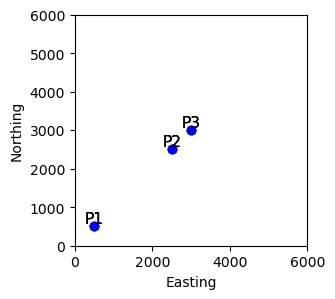

In [6]:
P.control_points = ([])
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "inverse_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
P.data, P.strat = functions.prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)     # Prepare geomodel inputs
P.geomodel = functions.create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

print(P.data)
print(P.geomodel.feature_names())
from geomodel_routines import plot_bores
plot_bores(P)

### 4. Set up Flow model (Reference)

In [7]:
# Initiate REFERENCE
from loop2flopy import Model
R = Model('ref', P, plan = 'vor', transect = 'con') 
R.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)

# Sort out Well screens to be over entire geological layer
from modelling_routines import find_cell_disv
P.wel_screens = []
for n in range(len(P.xypumpbores)):
    wel_icpl, wel_coords = find_cell_disv(P.xypumpbores[n][0], P.xypumpbores[n][1], R.xcyc)
    if P.geo_pl == 0:
        wel_top = R.top[wel_icpl]  
    else:   
        wel_top = R.botm[(P.geo_pl)* P.nls-1, wel_icpl]
    wel_bot = R.botm[(P.geo_pl + 1) * P.nls-1, wel_icpl]   
    print('Well coords ', wel_coords, ' Well screen top and bottom ', wel_top, wel_bot)
    P.wel_screens.append((wel_top, wel_bot))

# Creat OBS arrays
P.zobs = np.zeros((P.nobs,P.nzobs))
for n in range(len(P.xyobsbores)):
    obs_icpl, obs_coords = find_cell_disv(P.xyobsbores[n][0], P.xyobsbores[n][1], R.xcyc) # Cell id in plan
    for m in range(3): # For the top three geological layers
        if m == 0:
            lay_top = R.top[obs_icpl]  
        else:   
            lay_top = R.botm[(m)* P.nls-1, obs_icpl]
        lay_bot = R.botm[(m + 1) * P.nls-1, obs_icpl]   
        obsz = lay_bot + (lay_top-lay_bot)/2
        P.zobs[n][m] = obsz
print('\nobservation depths')
print(P.zobs)

# NEED TO PICKLE P.zobs and P.wel_screens
pickle.dump(P.wel_screens, open('../results/wel_screens.pkl','wb'))
pickle.dump(P.zobs, open('../results/zobs.pkl','wb'))

# Create flow model arrays
R.create_prop_arrays(P)         # Create property arrays (NPF)
R.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
print(R.modelname, ' has ', R.nnodes_div, ' nodes.')

   Creating lithology and discretisation arrays for  ref  ...
Modelling routines loaded!
Well coords  (np.float64(2000.0), np.float64(2000.0))  Well screen top and bottom  -186.0 -288.0
Well coords  (np.float64(2500.0), np.float64(2000.0))  Well screen top and bottom  -164.0 -266.0
Well coords  (np.float64(2000.0), np.float64(2500.0))  Well screen top and bottom  -164.0 -266.0
Well coords  (np.float64(2500.0), np.float64(2500.0))  Well screen top and bottom  -148.0 -250.0

observation depths
[[ -25. -162. -326.]
 [ -25.  -50. -101.]
 [ -25.  -60. -121.]
 [ -25.  -99. -199.]
 [ -25.  -50.  -73.]]
   Creating property arrays for  ref  ...
   Adding flow packages to  ref  ...
   Time taken =  1.205217
ref  has  13168  nodes.


### 5. Run Flow model (Reference)

In [8]:
results_workspace = '../results'
if not os.path.isdir(results_workspace):
    os.makedirs(results_workspace, exist_ok=True)
   
results = R.write_run_model(P, period = 'Steady', ic_array = P.strt)
R.gwf, R.head_ss, R.obs_ss, R.runtime_ss = results[0], results[1], results[2], results[-1]

   Writing simulation and gwf for  ref  ...
Period =  Steady 
   Model success =  True
   run_time =  14.286317


In [9]:
results = R.write_run_model(P, period = 'Past', ic_array = R.head_ss)
R.gwf, R.head_present, R.obs_present, R.runtime_past = results[0], results[1], results[2], results[-1]

   Writing simulation and gwf for  ref  ...
Period =  Past 
   Model success =  True
   run_time =  33.629617


In [10]:
results = R.write_run_model(P, period = 'Future', ic_array = R.head_present)
R.gwf, R.head_future, R.obs_future, R.runtime_future = results[0], results[1], results[2], results[-1]

   Writing simulation and gwf for  ref  ...
Period =  Future 
   Model success =  True
   run_time =  77.479963


### 6. Plot Results

Plotting routines loaded!


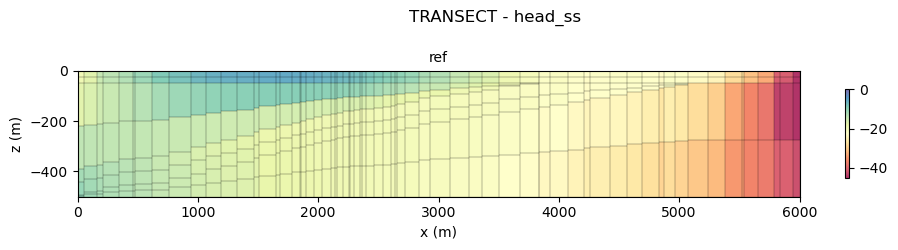

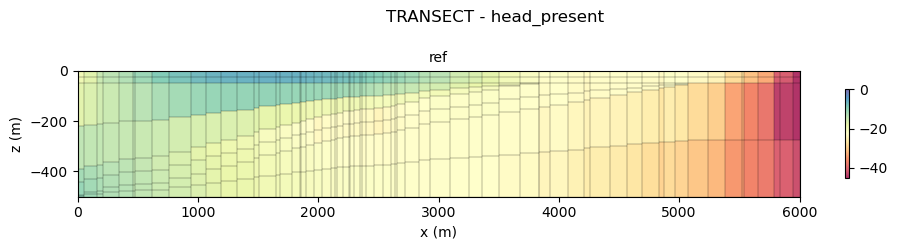

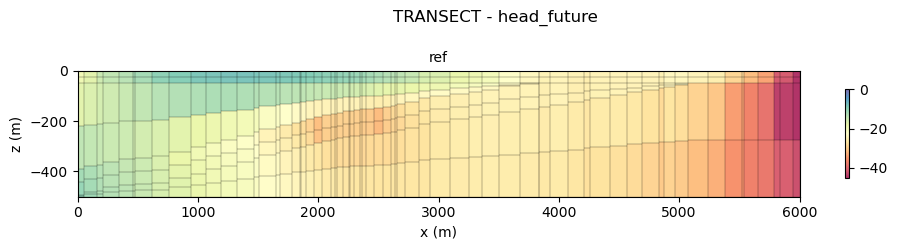

In [11]:
from plotting_routines import multiplot_prop_transect
multiplot_prop_transect(P, models = [R], array = 'head_ss', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_present', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_future', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, vmin = -45, vmax = 0)

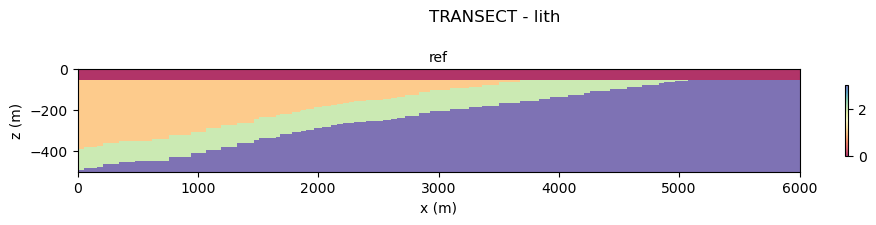

In [36]:
from plotting_routines import multiplot_vgrid_transect
multiplot_vgrid_transect(P, models = [R], array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1) 

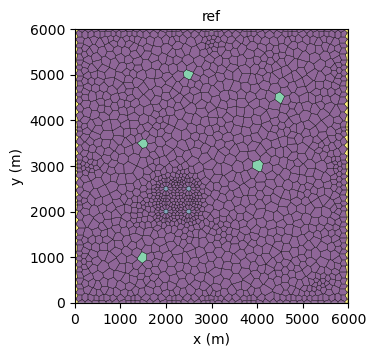

In [37]:
from plotting_routines import plot_flow_features
plot_flow_features(P, [R])

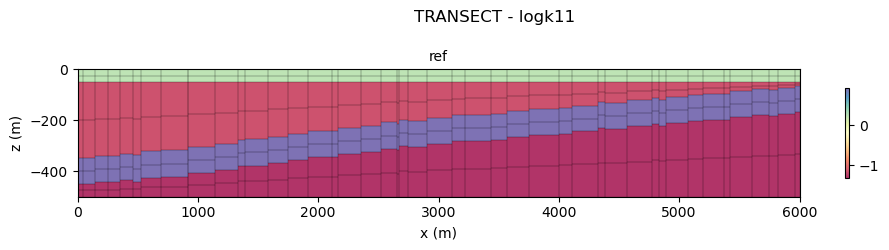

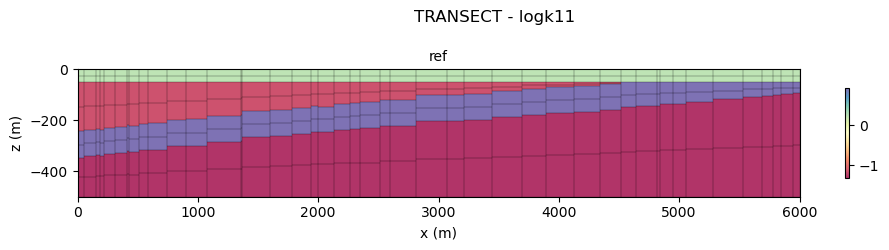

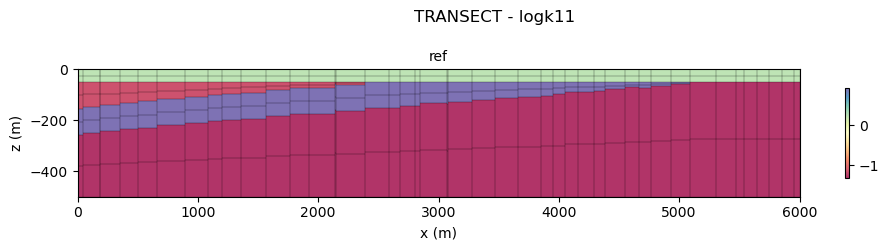

In [38]:
from plotting_routines import multiplot_prop_transect
y_ = [1000,3000,5000]
for y in y_:
    multiplot_prop_transect(P, models=[R], array ='logk11',X0=P.x0, Y0=y, X1=P.x1, Y1=y)#, vmin = -45, vmax = 0)

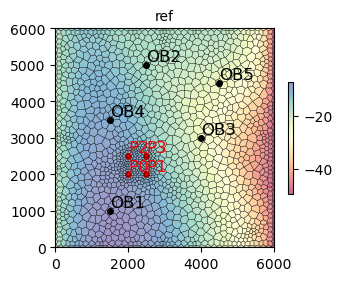

In [39]:
from plotting_routines import plot_bylayer
plot_bylayer(P, models = [R], layer = 0)#, vmin = -20, vmax = 5) 

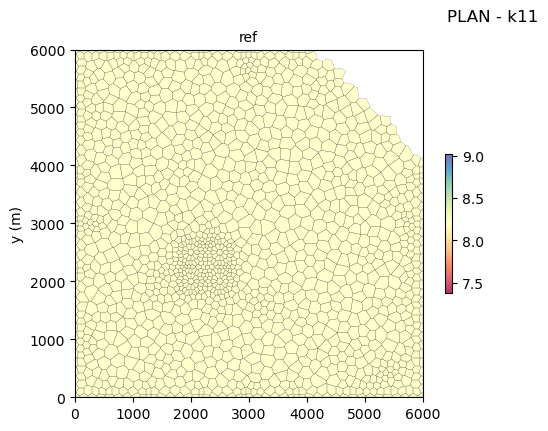

In [40]:
from plotting_routines import multiplot_prop_plan
multiplot_prop_plan(P, models = [R], array = 'k11', layer = 5)#, vmin = None, vmax = None)

In [41]:
vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(vtk_workspace, exist_ok=True)
    
f = os.path.join(vtk_workspace, "test", R.modelname)
R.gwf.export(f, fmt="vtk")

### 7. Create "truth" observations and plot observations

In [42]:
# Get convert obs package to arrays of oberservation heads
R.ref_steady  = process_obs_steady(P, R)
R.ref_past    = process_obs_past(P, R)
R.ref_future  = process_obs_future(P, R)

# Pickle reference results
fname = '../results/ref_ss.pkl'
pickle.dump(R.ref_steady, open(os.path.join(P.workspace, fname),'wb'))
fname = '../results/ref_past.pkl'
pickle.dump(R.ref_past, open(os.path.join(P.workspace, fname),'wb'))
fname = '../results/ref_future.pkl'
pickle.dump(R.ref_future, open(os.path.join(P.workspace, fname),'wb'))

# Get times
csv_file = os.path.join(P.workspace, R.modelname + "_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365

csv_file = os.path.join(P.workspace, R.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365+2

Text(0, 0.5, 'Head (m)')

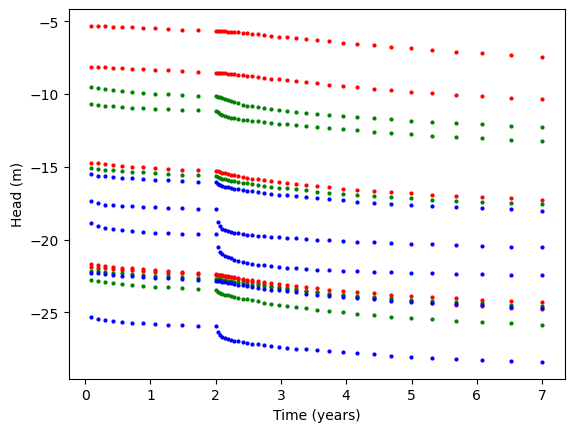

In [43]:
# PLOT REFERENCE OBSERVATIONS
import matplotlib.pyplot as plt
colors = ['red','green','blue']
R.ref_future.shape
for j in range(P.nobs):
    for i in range(P.nzobs):
        plt.plot(times_past, R.ref_past[j][i],'o', ms = 2, color = colors[i])
        plt.plot(times_future, R.ref_future[j][i],'o', ms = 2, color = colors[i])
plt.xlabel('Time (years)')
plt.ylabel('Head (m)')

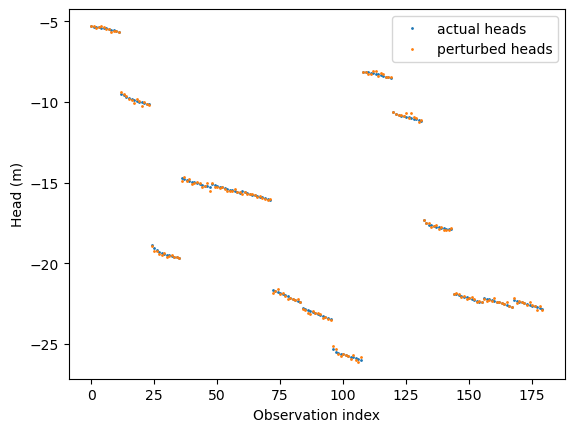

In [44]:
# CREATE SYNTHETIC OBSERVATIONS BY PERTURBING ACTUAL HEADS
err = 0.1
hobs_ref = np.copy(R.ref_past)    
for i in range(P.nobs):
    for j in range(P.nzobs):
        for k in range(hobs_ref.shape[2]):
            hobs_ref[i][j][k] += np.random.normal(0.,err) # Perturb samples either side of measurement
plt.plot(R.ref_past.flatten(), 'o', ms = 1, label = 'actual heads')
plt.plot(hobs_ref.flatten(),'o', ms = 1, label = 'perturbed heads')
plt.xlabel('Observation index')
plt.ylabel('Head (m)')
plt.legend()

### 8. Prepare PEST input arrays

In [45]:
# PRINTING TRUTH HEADS FOR HISTORY MATCHING (PEST - HEADS.INS)
hobs_ref.shape #(5, 3, 12)
for i in range(P.nobs):
    for j in range(P.nzobs):
        for k in range(hobs_ref.shape[2]):
            print('l1 [OBS%i_%i.%i]1:20' %(i, j, k))

l1 [OBS0_0.0]1:20
l1 [OBS0_0.1]1:20
l1 [OBS0_0.2]1:20
l1 [OBS0_0.3]1:20
l1 [OBS0_0.4]1:20
l1 [OBS0_0.5]1:20
l1 [OBS0_0.6]1:20
l1 [OBS0_0.7]1:20
l1 [OBS0_0.8]1:20
l1 [OBS0_0.9]1:20
l1 [OBS0_0.10]1:20
l1 [OBS0_0.11]1:20
l1 [OBS0_1.0]1:20
l1 [OBS0_1.1]1:20
l1 [OBS0_1.2]1:20
l1 [OBS0_1.3]1:20
l1 [OBS0_1.4]1:20
l1 [OBS0_1.5]1:20
l1 [OBS0_1.6]1:20
l1 [OBS0_1.7]1:20
l1 [OBS0_1.8]1:20
l1 [OBS0_1.9]1:20
l1 [OBS0_1.10]1:20
l1 [OBS0_1.11]1:20
l1 [OBS0_2.0]1:20
l1 [OBS0_2.1]1:20
l1 [OBS0_2.2]1:20
l1 [OBS0_2.3]1:20
l1 [OBS0_2.4]1:20
l1 [OBS0_2.5]1:20
l1 [OBS0_2.6]1:20
l1 [OBS0_2.7]1:20
l1 [OBS0_2.8]1:20
l1 [OBS0_2.9]1:20
l1 [OBS0_2.10]1:20
l1 [OBS0_2.11]1:20
l1 [OBS1_0.0]1:20
l1 [OBS1_0.1]1:20
l1 [OBS1_0.2]1:20
l1 [OBS1_0.3]1:20
l1 [OBS1_0.4]1:20
l1 [OBS1_0.5]1:20
l1 [OBS1_0.6]1:20
l1 [OBS1_0.7]1:20
l1 [OBS1_0.8]1:20
l1 [OBS1_0.9]1:20
l1 [OBS1_0.10]1:20
l1 [OBS1_0.11]1:20
l1 [OBS1_1.0]1:20
l1 [OBS1_1.1]1:20
l1 [OBS1_1.2]1:20
l1 [OBS1_1.3]1:20
l1 [OBS1_1.4]1:20
l1 [OBS1_1.5]1:20
l1 [OBS1_1.6]1:20
l1

In [46]:
# PRINTING TRUTH HEADS FOR HISTORY MATCHING (PEST - CONTROL.PST)
for i in range(P.nobs):
    for j in range(P.nzobs):
        for k in range(hobs_ref.shape[2]):
            print('OBS%i_%i.%i  %f  10.0  head' %(i, j, k, hobs_ref[i, j, k]))

OBS0_0.0  -5.329974  10.0  head
OBS0_0.1  -5.294855  10.0  head
OBS0_0.2  -5.416566  10.0  head
OBS0_0.3  -5.336585  10.0  head
OBS0_0.4  -5.323016  10.0  head
OBS0_0.5  -5.353759  10.0  head
OBS0_0.6  -5.500697  10.0  head
OBS0_0.7  -5.507577  10.0  head
OBS0_0.8  -5.642765  10.0  head
OBS0_0.9  -5.600607  10.0  head
OBS0_0.10  -5.591982  10.0  head
OBS0_0.11  -5.653474  10.0  head
OBS0_1.0  -9.366007  10.0  head
OBS0_1.1  -9.503346  10.0  head
OBS0_1.2  -9.623696  10.0  head
OBS0_1.3  -9.827852  10.0  head
OBS0_1.4  -9.877409  10.0  head
OBS0_1.5  -10.063309  10.0  head
OBS0_1.6  -9.831022  10.0  head
OBS0_1.7  -9.953740  10.0  head
OBS0_1.8  -10.251562  10.0  head
OBS0_1.9  -10.000704  10.0  head
OBS0_1.10  -10.116400  10.0  head
OBS0_1.11  -10.170990  10.0  head
OBS0_2.0  -18.912205  10.0  head
OBS0_2.1  -19.233762  10.0  head
OBS0_2.2  -19.269972  10.0  head
OBS0_2.3  -19.429591  10.0  head
OBS0_2.4  -19.480743  10.0  head
OBS0_2.5  -19.376042  10.0  head
OBS0_2.6  -19.588421  10.

### 9. Prepare parameter bounds

In [47]:
# LOG
k_min = [0, -2, 0, -2, -1, -2.5, -0.5, -2.5, -5, -5, -5]
k_max = [1, -1, 1, -1, 0, -1.5, 0.5, -1.5, -4, -4, -4]
k_mean = [(k_max[i] - k_min[i])/2 + k_min[i] for i in range(len(k_min))]

# LINEAR
print([10**i for i in k_max])
print([10**i for i in k_min])
print([10**i for i in k_mean])

[10, 0.1, 10, 0.1, 1, 0.03162277660168379, 3.1622776601683795, 0.03162277660168379, 0.0001, 0.0001, 0.0001]
[1, 0.01, 1, 0.01, 0.1, 0.0031622776601683794, 0.31622776601683794, 0.0031622776601683794, 1e-05, 1e-05, 1e-05]
[3.1622776601683795, 0.03162277660168379, 3.1622776601683795, 0.03162277660168379, 0.31622776601683794, 0.01, 1.0, 0.01, 3.1622776601683795e-05, 3.1622776601683795e-05, 3.1622776601683795e-05]


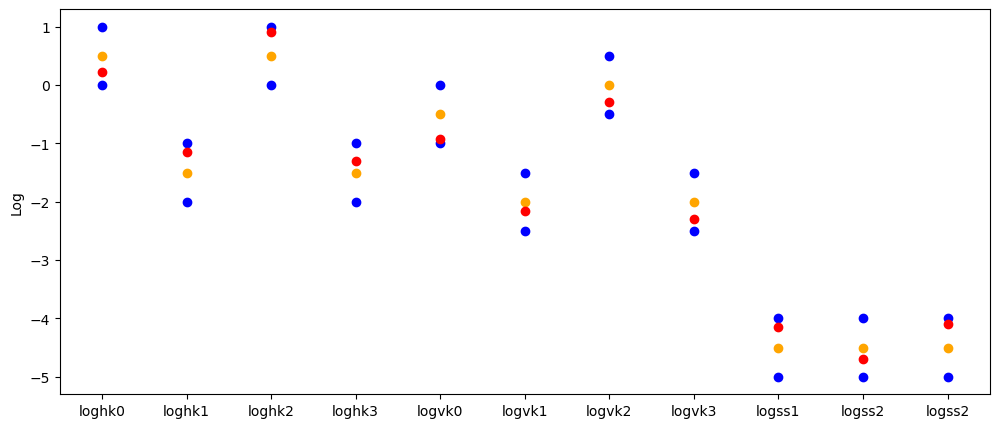

In [48]:
pickleoff = open('../results/reference.pkl','rb')
reference = pickle.load(pickleoff)
pickleoff.close()

# BLUE - MAX/MIN
# ORANGE - MEAN
# RED - ACTUAL
fig = plt.figure(figsize = (12,5))
plt.plot(np.linspace(0,10,11), k_min, 'o', color = 'blue')
plt.plot(np.linspace(0,10,11), k_max, 'o', color = 'blue')
plt.plot(np.linspace(0,10,11), k_mean, 'o', color = 'orange')
plt.plot(np.linspace(0,10,11), logfunc(reference[0] + reference[1] + reference[2][1:]), 'o', color = 'red')
plt.ylabel('Log')
plt.xticks(np.linspace(0,10,11), ['loghk0', 'loghk1', 'loghk2', 'loghk3', 
                                'logvk0', 'logvk1', 'logvk2', 'logvk3',
                                'logss1', 'logss2', 'logss2'])#, logss1, logss2, logss3, sy0, cp])
plt.show()

In [ ]:
rthrethrt

In [ ]:
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "pinchout_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
    
# Include this here when ignoring structural parameters
#P.control_points = (['CP1', 'control', 3000, 3000, -100, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
#P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
#P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

def update_model(P, hk0, hk1, hk2, hk3, vk0, vk1, vk2, vk3, ss1, ss2, ss3, sy0, cp):
    print(hk0, hk1, hk2, hk3, vk0, vk1, vk2, vk3, ss1, ss2, ss3, sy0, cp)
    del P.hk
    del P.vk
    del P.ss
    del P.sy
    #P.hk = [10**loghk0, 10**loghk1, 10**loghk2, 10**loghk3] #[1, 0.1, 10, 0.1] 
    P.hk = [hk0, hk1, hk2, hk3]
    #P.vk = [10**logvk0, 10**logvk1, 10**logvk2, 10**logvk3] #[i/10 for i in P.hk]
    P.vk = [vk0, vk1, vk2, vk3]
    #P.ss = [0.00009, 10**logss1, 10**logss2, 10**logss3]
    P.ss = [0.00009, ss1, ss2, ss3]
    P.sy = [sy0, 0.1, 0.1,0.1]#[sy0, 0.1, 0.1, 0.1]
    P.control_points = (['CP1', 'control', 3000, 3000, -cp, -200, 'c', 'lower', 0., 0., 1.],) 
    
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = Model('run', P, plan = 'vor', transect = 'con') # Create flow model 
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    
    results = M.write_run_model(P, period = 'Steady', ic_array = P.strt)   
    M.gwf, M.head_ss, M.obs_ss = results[0], results[1], results[2]
    
    results = M.write_run_model(P, period = 'Past', ic_array = M.head_ss)   
    M.gwf, M.head_past, M.obs_past = results[0], results[1], results[2]
     
    #hobs_steady = process_obs_steady(P, M)
    hobs_past = process_obs_past(P, M)
    print(hobs_past.shape)
    np.savetxt('../modelfiles/heads.txt', hobs_past.flatten())#, delimiter=' ')
    return(hobs_past.flatten())#hobs_past, M)

In [ ]:
### Run model with truth parameters
heads = update_model(P, 
             1.7, 0.07, 8.2, 0.05,
             0.12,0.007,0.51,0.005,
             0.00007, 0.00002, 0.00008,
             0.12, 200)
       

In [ ]:
plt.plot(heads - hobs_ref.flatten())

In [ ]:
def run_prediction(M, ic_array):
    results = M.write_run_model(P, period = 'Future', ic_array = ic_array)   
    M.gwf, M.head_future, M.obs_future = results[0], results[1], results[2]
    hpred = process_obs_future(P, M)
    return hpred

### MCMC BELOW HERE

In [ ]:
def Likelihood(obs, mod, err):
    return(np.sum(-(obs-mod)**2/(2*err**2)))

#from DREAM import *
%run ../../Lab_tools/Uncertainty_tools/DREAM.py

Unif = [] # True = Uniform, False = Normal
Log = []  # ?? Just put False
Mean = []
Width = []  # for uniform distributon the range,  for normal, the standard deviation
Min = []
Max = []

###K values
for i in range(len(P.hk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(10**k_mean[i])
    Width.append((10**k_max[i] - 10**k_min[i])/2.)
    Min.append(10**k_min[i]) 
    Max.append(10**k_max[i]) 

#make this anisotropy
for i in range(len(P.vk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(10**k_mean[i+4])
    Width.append((10**k_max[i+4] - 10**k_min[i+4])/2.)
    Min.append(10**k_min[i+4]) 
    Max.append(10**k_max[i+4]) # Changed 18/8
    
for i in range(3): # 1e-4 to 1e-6 # Botom 3 layers
    Unif.append(True) # True if uniform, False if normal
    Log.append(True) # Ignore
    Mean.append(5e-5)
    Width.append(2.5e-5)
    Min.append(1e-5) 
    Max.append(1e-4)
    
#Sy top geo layer #0.05 - 0.2
Unif.append(True)
Log.append(False)
Mean.append(0.125)
Width.append(0.075)
Min.append(0.05)
Max.append(0.2)

#Control points z value
Unif.append(True)
Log.append(False)
Mean.append(-125)
Width.append(125)
Min.append(-250)
Max.append(0)

In [ ]:
MCMC = [Min, Mean, Max]
pickle.dump(MCMC, open('../results/MCMC.pkl','wb'))

#### Set up DREAM and define "run model" function

In [ ]:
## DREAM for Steady State
nchains = 5     #number of parallel chains 
npars = len(Mean)  #number of parameters
nburn = 200
minsamp = 169 # minimum number of samples

D = DREAM(nchains, npars, nburn = nburn, npairs = 1) #nburn is burn in perion, npairs defines how you sample
D.par_set(Log,Unif,Mean,Width,Min,Max) #initialise the class
D.set_CR(ncr=3)  #crossover testing thingy. Use 3
D.k = 1 # Number of things to try each chain. Numbers other than 1 can give weird results for some models

In [ ]:
'''# Load DREAM results
pickleoff = open('../results/dream_pars_chain_0_.pkl','rb') # dream_pars (122, 13)
dream_pars_0 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_1_.pkl','rb') # dream_pars (122, 13)
dream_pars_1 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_2_.pkl','rb') # dream_pars (122, 13)
dream_pars_2 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_3_.pkl','rb') # dream_pars (122, 13)
dream_pars_3 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_4_.pkl','rb') # dream_pars (122, 13)
dream_pars_4 = pickle.load(pickleoff)
pickleoff.close()

D.chains[0].current = dream_pars_0[-1,:]
D.chains[1].current = dream_pars_1[-1,:]
D.chains[2].current = dream_pars_2[-1,:]
D.chains[3].current = dream_pars_3[-1,:]
D.chains[4].current = dream_pars_4[-1,:]'''


In [ ]:
#this function and argument statement are for the labtools dream implementation.

def L_func(Prop, P, hobs_ref, err):
    hmod, M = update_model(P,
                        Prop[0],
                        Prop[1],
                        Prop[2],
                        Prop[3],
                        Prop[4],
                        Prop[5],
                        Prop[6],
                        Prop[7],
                        Prop[8],
                        Prop[9],
                        Prop[10],
                        Prop[11],
                        Prop[12],
                        ) 
    a = np.array(hobs_ref) 
    b = np.array(hmod)
    P.hmod = hmod
    P.M = M
    return(Likelihood(a,b,err))
    
    
args = (P, hobs_ref, err,) # P - project object, hobs_ref - real observations, err - 
    
def result_func(Prop,P):
    M = P.M
    hpred = run_prediction(M, ic_array = M.head_past)
    overall = np.append(P.hmod,hpred,axis=2)
    #print(overall)
    return(overall)

Rfunc_args = (P,)
    

In [ ]:
def run_prediction(M, ic_array):
    results = M.write_run_model(P, period = 'Future', ic_array = ic_array)   
    M.gwf, M.head_future, M.obs_future = results[0], results[1], results[2]
    hpred = process_obs_future(P, M)
    return hpred

In [ ]:
"""for i in range(nchains):
    D.chains[i].current = ldum[i]"""


results = Dream_ZS(D,       # DREAM class being used.
                   L_func,  # function that recieves the proposed pars, places in model, runs model & returns Likelihood 
                   args,    # contains all the args for the model outside of the parameters
                   result_func = result_func,      # save the model outputs
                   result_func_args = Rfunc_args,  
                   minsamp = minsamp,         
                   print_freq = 1,
                   Test = False,      # If True, only initial likelihoods obtained
                   lookback = 10,
                   R_overide = False)  # Stops even if R=1.2 not reached

In [ ]:
ldum = []
for i in range(D.nc):
    ldum.append(D.chains[i].current)
ldum

In [ ]:
sim = flopy.mf6.MFSimulation.load(sim_name = 'sim', sim_ws = '../modelfiles')
gwf = sim.get_model('run')
print("minimum cell thickness = %f at node %i" %(gwf.modelgrid.thick.min(), gwf.modelgrid.thick[node]))

In [ ]:
node = 8114-1

X = gwf.modelgrid.xyzcellcenters[0][node]
Y = gwf.modelgrid.xyzcellcenters[1][node]
Z = gwf.modelgrid.xyzcellcenters[2][0][node]
print("XYZ problem = ", X,Y,Z)

xv = gwf.modelgrid.xyzvertices[0][node]
yv = gwf.modelgrid.xyzvertices[1][node]
zv_top = gwf.modelgrid.xyzvertices[2][0][node]
zv_bot = gwf.modelgrid.xyzvertices[2][1][node]
xv, yv, zv_top, zv_bot
print('cell width approx ', max(xv) - min(xv))
print('cell length approx ', max(yv) - min(yv))
print('cell thickness', zv_top - zv_bot)

plot_problem_cell(P, gwf, X=X, Y=Y, Z=Z)

In [ ]:
#dir(P.M)
len(results)#[0][0][0]) #260,5,3,42

In [ ]:
for i in range(nchains):
    plt.plot(D.chains[i].likelihood)
plt.xlim(nburn,)
plt.ylim(-2500,0)

#### Plot parameter estimates

In [ ]:
fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
B = np.loadtxt(fname)[:,1:]
n = int(B.shape[0]/nchains)
A = B.reshape((n, nchains, npars))
B.shape

In [ ]:
#fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
#B = np.loadtxt(fname)[nburn*nchains:,1:]
#A = B.reshape((minsamp-nburn, nchains, npars))

In [ ]:
for i in range(npars-1,npars):
    for j in range(nchains):
        plt.plot(A[:,j,i], 'o',ms=3)
plt.plot((0, minsamp),(-200, -200), color = 'black', lw = 3)
plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.xlabel('samples x chains')
plt.ylabel('control point z (m)')
plt.axvline(nburn)
plt.ylim(-250,0)

In [ ]:
hk_ref = [1, 0.1, 5, 0.1] 
vk_ref = [i/10 for i in hk_ref]
ss_ref = [ 0.00005, 0.00005, 0.00005]

In [ ]:
fig, ax = plt.subplots(4,4, figsize = (10,10))

# Hk
for i in range(4):
    ax = plt.subplot(4,4,i+1)
    ax.hist(A[nburn:,:,i].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(hk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Hk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i], Max[i]])
    if i != 0: ax.set_yticks([])

# Vk        
for i in range(4):
    ax = plt.subplot(4,4,i+5)
    ax.hist(A[nburn:,:,i+4].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(vk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Vk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+4], Max[i+4]])
    if i != 0: ax.set_yticks([])
        
# Sy
ax = plt.subplot(4,4,9)
ax.hist(A[nburn:,:,-2].flatten(), bins=30, range = (0,0.2))
plt.axvline(P.sy[0], color = 'black', lw = 1)
ax.set_xlabel('Sy (Lay 0)')
ax.set_ylabel('Frequency')
ax.set_xlim([0, 0.2])
ax.set_ylim([0,500])

#Ss
for i in range(3):
    ax = plt.subplot(4,4,i+10)
    ax.hist(A[nburn:,:,i+8].flatten(), bins=30, range = (-5,-4))
    plt.axvline(logfunc(ss_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Ss (Lay {i+1})')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+8], Max[i+8]])
    ax.set_yticks([])

# CPz    
ax = plt.subplot(4,4,13)    
ax.hist(A[nburn:,:,-1].flatten(), bins=30, range = (-250,0))
plt.axvline(-200, color = 'black', lw = 1)
ax.set_xlabel('Control Point Z (m)')
ax.set_ylabel('Frequency')
ax.set_xlim([-250,0])

ax = plt.subplot(4,4,14) 
ax.set_axis_off()
ax = plt.subplot(4,4,15) 
ax.set_axis_off()
ax = plt.subplot(4,4,16) 
ax.set_axis_off()
        
plt.subplots_adjust(wspace=0.5)#, hspace=0.1)    
plt.tight_layout()  
fig.savefig('../figures/figure7', dpi=450) 

In [ ]:
meanK = []
meanX = []
meanY = []
meanL = []
meanTheta = []
varK = []
varX = []
varY = []
varL = []
varTheta = []
for i in range(1,np.shape(B)[0]):
    meanK.append(np.mean(B[:i,0]))
    varK.append(np.var(B[:i,0]))
    meanX.append(np.mean(B[:i,1]))
    varX.append(np.var(B[:i,1]))
    meanY.append(np.mean(B[:i,2]))
    varY.append(np.var(B[:i,2]))
    meanL.append(np.mean(B[:i,3]))
    varL.append(np.var(B[:i,3]))
    meanTheta.append(np.mean(B[:i,4]))
    varTheta.append(np.var(B[:i,4]))

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
for k in range(5):
    for j in range(npars-2):
        for i in range(len(A) - nburn):        
            ax.plot(j, A[i][k][j],'o', ms = 2.)

for j in range(npars-2):
    ax.plot(j, Mean[j], 'o', ms = 5., color = 'black')
#ax.set_xlabel('Parameter Number')
ax.set_xticks(np.arange(0,npars-2,1))
ax.set_xticklabels(['hk0', 'hk1', 'hk2', 'hk3', 'vk0', 'vk1', 'vk2', 'vk3','ss1','ss2','ss3'])
ax.set_ylabel('Log Value')
ax.set_ylim([-5,1.5])

### Compare predictions against reality

In [ ]:
# Get times
csv_file = os.path.join(P.workspace, "ref_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365 

csv_file = os.path.join(P.workspace, M.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365 

times = times_past.tolist() + [i +2 for i in times_future.tolist()]

In [ ]:
# Load REFERENCE results
fname = '../results/ref_past.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_past = pickle.load(pickleoff)
pickleoff.close()
ref_past = np.array(ref_past)

fname = '../results/ref_future.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_future = pickle.load(pickleoff)
pickleoff.close()
ref_future = np.array(ref_future)

ref_results = np.append(ref_past, ref_future, axis=2)

# Load DREAM results
fname = '../results/dream_results.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
dream_results = pickle.load(pickleoff)
pickleoff.close()
dream_results = np.array(dream_results)

### Plot reality vs predicted

In [ ]:
# number of ACCEPTED parameter set past/future results, nobs_xy, nobs_z, nts
print('dream_results shape', dream_results.shape)   
print('ref_results shape', ref_results.shape) 

In [ ]:
fig = plt.figure(figsize=(3,6))
#plt.suptitle(modelname, size = 14)
colors = ['red', 'blue','green']
for j in range(5):  # OBS in xy
    ax = plt.subplot(5, 1, j+1,aspect='auto')
    ax.set_title('Obs %i' %(j))
        
    for k in range(3): # OBS in z
        for i in range(len(dream_results)): 
            ax.plot(times, dream_results[i, j, k], '-', color = colors[k], alpha = 0.6, lw = 0.1 ) 
        
        ax.plot(times, ref_results[j, k], lw = 1.5, color = 'black')#colors[k]) # Plot truth
    if j == 4: ax.set_xlabel('Time (years)', size = 10)
    if j < 4: ax.set_xticks([])

    if n == 0 or n == 3 or n == 6: ax.set_ylabel('Head (m)', size = 10)
    #ax.axvline(2)
    ax.set_ylim([-30,0])
plt.tight_layout()    
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(10,8))

for k in range(3): # OBS in z
    for j in range(5):  # OBS in xy
    
        ax = plt.subplot(3, 5, k * 5 + j + 1,aspect='auto')
        ax.set_title('Obs %i\nz = %im' %(j, P.zobs[j,k]), size = 8)
        ax.hist(obs_future[:, j, k, -1], bins = 5)
        ax.axvline(ref_future[j, k, -1], lw = 1, color = 'black') # Plot truth
        if j == 0: ax.set_ylabel('Frequency', size = 10)
        if k == 2: ax.set_ylabel('Predicted head (m)', size = 10)
        #ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_xlim([ref_future[j, k, -1] - 2, ref_future[j, k,-1] + 2])
        
        ax.set_xticks(ticks=[ref_future[j, k, -1] - 2, ref_future[j, k, -1], ref_future[j, k, -1] + 2], 
                      labels=[str(round(float(ref_future[j, k, -1] - 2),1)), 
                              str(round(float(ref_future[j, k, -1]),1)), 
                              str(round(float(ref_future[j, k, -1] + 2),1)),],
                      size = 8)
    
plt.subplots_adjust(wspace=0.4, hspace=0.4)    
plt.tight_layout()  
fig.savefig('../figures/figure8', dpi=450) 
plt.show()

In [ ]:
Scrap Code

In [ ]:
#help(flopy.discretization.StructuredGrid)

#cell2dcar = mgs.get_gridprops_vertexgrid()
#lrc_list = mgs.get_lrc()
#node = mgs.get_node(lrc_list)

#verts = sg.verts
#xycenters = sg.xycenters
#xyzvertices = sg.xyzvertices

def convert_to_disu(mgs, idx, dztol):
    global d2d
    
    delr = mgs.delr
    delc = mgs.delc
    top = mgs.top
    botm = mgs.botm
    key = list(parameters.keys())[idx]
    staggered = parameters[key]['staggered']
    d2d = Dis2Disu(delr, delc, top, botm, staggered=staggered, dztol=dztol)
    
    return (d2d)

gridprops = vor.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(**gridprops, nlay=1)
ibd = np.zeros(vgrid.ncpl, dtype=int)
gi = flopy.utils.GridIntersect(vgrid)

# identify cells on left edge
line = LineString([(P.x0, P.y0), (P.x0, P.y1)])
cells0 = gi.intersect(line)["cellids"]
cells0 = np.array(list(cells0))
ibd[cells0] = 1

# identify cells on right edge
line = LineString([(P.x1, P.y0), (P.x1, P.y1)])
cells1 = gi.intersect(line)["cellids"]
cells1 = np.array(list(cells1))
ibd[cells1] = 2

# identify cell
for i in P.xypumpbores:
    point = Point((i[0], i[1]))
cells2 = gi.intersect(point)["cellids"]
cells2 = np.array(list(cells2))
ibd[cells2] = 3

if True:
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(1, 1, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(modelgrid=vgrid)
    pmv.plot_array(ibd, alpha = 0.6)
    vor.plot(ax=ax, edgecolor='black', lw = 0.5)

In [ ]:
'''from flopy.export import vtk
from pathlib import Path
from tempfile import TemporaryDirectory

nam_file = "CV.nam"
ml = flopy.modflow.Modflow.load(nam_file, model_ws=P.workspace, check=False)

tempdir = TemporaryDirectory()
workspace = Path(tempdir.name)

output_dir = workspace / "arrays_test"
output_dir.mkdir(exist_ok=True)

output_dir'''

In [ ]:
# Plot observations
colors = ['black', 'red', 'green', 'purple', 'orange']
marker_styles = ['s', 's', 's', 'o', 'o', 'o'] #['s', '^', 'p', 's', '^', 'p']    
line_styles = ['dashed', 'dashed','dashed','dotted', 'dotted','dotted','solid']  
fill_color = ['red', 'green', 'purple', 'white', 'white', 'white']
#modelnames = [M.modelname for M in models]

 
#---------- STEADY -------------
models = [M]
fig = plt.figure(figsize = (12,3))
fig.suptitle('Steady state heads')
    
for ob in range(P.nobs): # New figure for each obs bore (OB1, OB2, OB3, OB4)
    ax = plt.subplot(1,5,ob+1)#, aspect = 'equal')
    ax.set_title(P.idobsbores[ob], size = 10) 

    for i, model in enumerate(models): # colored line for each model
        for z in range(len(P.zobs)): # New figure for each obs bore (OB1, OB2, OB3, OB4)
            ax.plot(z, model.hobs_steady[ob,z][0], 'o', c = colors[i],#, marker = marker_styles[i], s = 20,)
                    label = M.modelname)
    
    #ax.set_xlim([10,30])
    ax.set_ylabel('Obs Depth (m)')
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(P.zobs)
    ax.set_ylim([-20,10])
    if ob > 0: ax.set_yticks([])
    #ax.set_yticks([30, 40, 50, 60])
    if ob == 0: ax.set_ylabel('Head (m)')
    
            
handles, labels = plt.gca().get_legend_handles_labels()
ax = plt.subplot(1,5,5, aspect = 'equal')
ax.set_axis_off()
ax.legend(handles=handles)
plt.show()

In [ ]:
### CODE TO TEST CONVERGENCE ISSUES BY PLOTTING PROBLEM CELL

def plot_problem_cell(P, gwf, X, Y, Z, vmin = None, vmax = None): # array needs to be a string of a property eg. 'k11', 'angle2'
    a = gwf.npf.k.get_data()
    fig = plt.figure(figsize = (10,3))
    ax = plt.subplot(121)
    ax.set_title("West-East Transect\nY = %i" %(Y))
    xsect = flopy.plot.PlotCrossSection(modelgrid=gwf.modelgrid, line={"line": [(P.x0, Y),(P.x1, Y)]},
                                        geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(X, Z, 'o', color = 'red')
    ax.set_xlabel('x (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    ax = plt.subplot(122)
    ax.set_title("South-North Transect\nX = %i" %(X))
    xsect = flopy.plot.PlotCrossSection(modelgrid=gwf.modelgrid, line={"line": [(X, P.y0),(X, P.y1)]},
                                        geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(Y, Z, 'o', color = 'red')
    ax.set_xlabel('y (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    #ax.set_xlim([1000, 3000])
    #ax.set_ylim([-68, -48])
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    fig = plt.figure(figsize = (6,6))
    ax = plt.subplot(111)
    ax.set_title("Plan")
    mapview = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid, layer = 0)#, geographic_coords=True)
    plan = mapview.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(X, Y, 'o', color = 'red')
    ax.set_xlabel('x (m)', size = 10)
    ax.set_ylabel('y (m)', size = 10)
    linecollection = mapview.plot_grid(lw = 0.1, color = 'black') 
    
    #plt.colorbar(csa, shrink = 0.7)
    plt.tight_layout()  
    plt.show()  
    
#loghk0, loghk1, loghk2, loghk3 = 0.27972511989404736, -1.9442518204215036, 0.38322898929495725, -1.2905279279633497
#logvk0, logvk1, logvk2, logvk3 =  -0.5824396583949223, -2.4754872268614063, -0.3344909931386087, -2.640047841390039
#logss1, logss2, logss3 = -4.517405710106817, -4.610738280002378, -4.712335701038782
#sy0 =  0.11386417979259696
#cp =  -160.4664408080099
#
#P.hk = [10**loghk0, 10**loghk1, 10**loghk2, 10**loghk3]
#P.vk = [10**logvk0, 10**logvk1, 10**logvk2, 10**logvk3]
#P.ss = [0.00009, 10**logss1, 10**logss2, 10**logss3]
#P.sy = [sy0, 0.1, 0.1, 0.1]
#
## Initiate TEST
#P.control_points = (['CP1', 'control', 3000, 3000, cp, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
#P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
#P.geomodel = create_geomodel_loopshowcase(P, include_fault = False)
#T = Model('test', P, plan = 'vor', transect = 'con') 
#T.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)
#T.create_prop_arrays(P)         # Create property arrays (NPF)
#T.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
#print(T.modelname, ' has ', T.ncell_disu, ' nodes.')
#
#T.gwf, T.head_ss, T.obs_ss, T.runtime_ss = T.write_run_model(P, period = 'Steady', ic_array = P.strt) 
#T.gwf, T.head_present, T.obs_present, T.runtime_past = T.write_run_model(P, period = 'Past', ic_array = T.head_ss)
#T.gwf, T.head_future, T.obs_future, T.runtime_future = T.write_run_model(P, period = 'Future', ic_array = T.head_present)
#
#T.angle2_disu = T.gwf.npf.angle2.array
#multiplot_prop_transect(P, models = [T], array = 'angle2_disu', X0=P.x0, Y0=P.y0, X1=P.x1, Y1=P.y1)

#node = 2731-1
#sim = flopy.mf6.MFSimulation.load(sim_name = 'sim', sim_ws = '../modelfiles')
#gwf = sim.get_model('test')
#
#print("minimum cell thickness = %f at node %i" %(T.gwf.modelgrid.thick.min(), T.gwf.modelgrid.thick[node]))
#
#X = T.gwf.modelgrid.xyzcellcenters[0][node]
#Y = T.gwf.modelgrid.xyzcellcenters[1][node]
#Z = T.gwf.modelgrid.xyzcellcenters[2][0][node]
#print("XYZ problem = ", X,Y,Z)
#
#xv = T.gwf.modelgrid.xyzvertices[0][node]
#yv = T.gwf.modelgrid.xyzvertices[1][node]
#zv_top = T.gwf.modelgrid.xyzvertices[2][0][node]
#zv_bot = T.gwf.modelgrid.xyzvertices[2][1][node]
#xv, yv, zv_top, zv_bot
#print('cell width approx ', max(xv) - min(xv))
#print('cell length approx ', max(yv) - min(yv))
#print('cell thickness', zv_top - zv_bot)
#
#plot_problem_cell(P, T.gwf, X=X, Y=Y, Z=Z)

In [ ]:
"""workspace = 'vtk_files'
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

model_output_dir = os.path.join(workspace, "model_output_test")
M.gwf.export(model_output_dir, fmt="vtk")

from flopy.export import vtk
fname = '{}.hds'.format(M.modelname)
print(os.path.join(P.workspace, fname))
hds = flopy.utils.binaryfile.HeadFile(os.path.join(P.workspace, fname))  


vtkobj = vtk.Vtk(M.gwf, xml=True, pvd=True, vertical_exageration=2)
vtkobj.add_heads(hds)
vtkobj.write(os.path.join(workspace, "heads_output_test", "KW.vtu"))"""